# AI4PH Data Challenge

Summer 2024

**Yves Nsoga** 
- PhD Candidate Biomedical Engineering
- University of Calgary
- [Data Intelligence for Health Lab](https://cumming.ucalgary.ca/dih)    

In [1]:
# import all packages here 

import pandas as pd
import numpy as np
import cv2

import os
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, models
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import imutils
from skimage import io, transform
import plotly_express as px
from sklearn.metrics import r2_score
from PIL import Image
import math
from sklearn.preprocessing import LabelEncoder

### Data Preprocessing

In [126]:
# Util functions here 
def stich_image(img_paths: list):
    """stich images with  overlaping to  generate a panoramic view of the POstal  code

    :param img_paths: a list  of image paths
    return panoramic_image
    """
    imgs = []
    for img_path in img_paths:
        img = cv2.imread(img_path)
        imgs.append(img)
    stitchy = cv2.createStitcher() if imutils.is_cv3() else cv2.Stitcher_create()
    (dummy, stiched_output) = stitchy.stitch(imgs)
    if dummy == cv2.STITCHER_OK:
        return stiched_output
    
def crop(stitched: np.array):
    """crop stiched image

    :param image: Image to resize
    :param dimension:  Expected (width, height) of new image, defaults to (800,250)
    :Returns image: Resized image
    """
    stitched = cv2.copyMakeBorder(stitched, 10, 10, 10, 10,
			cv2.BORDER_CONSTANT, (0, 0, 0))
    # convert the stitched image to grayscale and threshold it
    # such that all pixels greater than zero are set to 255
    # (foreground) while all others remain 0 (background)
    gray = cv2.cvtColor(stitched,cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY)[1]
	# find all external contours in the threshold image then find
	# the *largest* contour which will be the contour/outline of
	# the stitched image
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
	# allocate memory for the mask which will contain the
	# rectangular bounding box of the stitched image region
    mask = np.zeros(thresh.shape, dtype="uint8")
    (x, y, w, h) = cv2.boundingRect(c)
    cv2.rectangle(mask, (x, y), (x + w, y + h), 255, -1)
    minRect = mask.copy()
    sub = mask.copy()
	# keep looping until there are no non-zero pixels left in the
	# subtracted image
    while cv2.countNonZero(sub) > 0:
		# erode the minimum rectangular mask and then subtract
		# the thresholded image from the minimum rectangular mask
		# so we can count if there are any non-zero pixels left
        minRect = cv2.erode(minRect, None)
        sub = cv2.subtract(minRect, thresh)
    cnts = cv2.findContours(minRect.copy(), cv2.RETR_EXTERNAL,
    cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    (x, y, w, h) = cv2.boundingRect(c)
	# use the bounding box coordinates to extract the our final
	# stitched image
    stitched = stitched[y:y + h, x:x + w]
    return stitched



def generate_panorama(root_folder):
    """
    """
    postal_codes = os.listdir(root_folder)
    for index, postal_code in enumerate(postal_codes):
        print(f"**** starting processing postal  code {postal_code} images")
        image_list=[]
        image_path = os.path.join(root_folder,
                                postal_codes[index])

        try:
            for images in os.listdir(image_path):
                # Selecting only horizontal images remove +'_0' to  use all  12 images,  but this might not work  for all images
                if (images.endswith(".png") and images.startswith(postal_code+'_0')):
                    image_list.append(os.path.join(image_path,
                                                images))
            panorama_view = stich_image(image_list)
            panorama_view_cropped = crop(panorama_view)
            cv2.imwrite(os.path.join(image_path,
                        "pano_view.png"), panorama_view_cropped)
            print(f"*** processing postal code {postal_code} images done ")
        except Exception as e:
            print(f"stiching of Images of postal code:{postal_code} failed, causes:{e}")
                

class zone_panorama_dataset(Dataset):
    """
    """
    def __init__(self,csv_file,root_dir,transform=None):
        """_summary_

        :param csv_file: _description_
        :type csv_file: _type_
        :param root_dir: _description_
        :type root_dir: _type_
        :param transform: _description_, defaults to None
        :type transform: _type_, optional
        """
        self.depravation_indices_data = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform =transform
        self.samples = []
        postal_codes = os.listdir(self.root_dir)

        for  postal_code in postal_codes:
            image_path = os.path.join(self.root_dir,
                                      postal_code)
            
            try:
                if os.path.exists(os.path.join(image_path,"pano_view.png")):
                    image = io.imread(os.path.join(image_path,"pano_view.png"))
                    sample = {"image": image,
                            "POSTAL": postal_code,
                            "SCOREMAT": self.depravation_indices_data["SCOREMAT"].loc[self.depravation_indices_data["POSTALCODE_15"] == postal_code].values[0],
                            "SCORESOC": self.depravation_indices_data["SCORESOC"].loc[self.depravation_indices_data["POSTALCODE_15"] == postal_code].values[0]}
                    if self.transform:
                        sample = self.transform(sample)
                    self.samples.append(sample)
            except Exception as e:
                print(e)
                pass
        

    def __len__(self):
        return len(self.samples)
    def __getitem__(self, index):
        if torch.is_tensor(index):
            index =index.tolist()
        return self.samples[index]


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image= sample['image']
        score_mat = np.asarray([sample["SCOREMAT"]])
        score_soc = np.asarray([sample["SCORESOC"]])

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C x H x W
        trans = transforms.ToTensor()
        sample['image'] = trans(image)
        sample["SCOREMAT"] = torch.from_numpy(score_mat)
        sample["SCORESOC"] = torch.from_numpy(score_soc)
        return sample


class Resize(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image = sample['image']
        rescaled_image = transform.resize(image, (450, 450))
        sample['image'] = rescaled_image
        return sample
    
class Augment(object):
    """
    """
    def __call__(self, sample):
        image = Image.fromarray(sample['image'])
        trans = transforms.AutoAugment(
            transforms.autoaugment.AutoAugmentPolicy.IMAGENET)
        transformed_image = trans(image)
        sample['image'] = np.array(transformed_image)
        return sample
    

class Pad(object):
    """
    """
    def __call__(self, sample):
        img_size = sample['image'].shape
        image = Image.fromarray(sample['image'])
        trans = transforms.Pad((0, (img_size[1]-img_size[0])//2))
        transformed_image = trans(image)
        sample['image'] = np.array(transformed_image)
        return sample
    

### Regression

In [125]:

class LeNet(nn.Module):
	def __init__(self, numChannels, classes):
		# call the parent constructor
		super(LeNet, self).__init__()
		# initialize first set of CONV => RELU => POOL layers
		self.conv1 = nn.Conv2d(in_channels=numChannels, out_channels=20,
                      kernel_size=(5, 5))
		self.relu1 = nn.ReLU()
		self.maxpool1 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
		# initialize second set of CONV => RELU => POOL layers
		self.conv2 = nn.Conv2d(in_channels=20, out_channels=50,
                      kernel_size=(5, 5))
		self.relu2 = nn.ReLU()
		self.maxpool2 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
		# initialize first (and only) set of FC => RELU layers
		self.fc1 = nn.Linear(in_features=140450 , out_features=2000)
		self.relu3 = nn.ReLU()
		# initialize our softmax classifier
		self.fc2 = nn.Linear(in_features=2000, out_features=classes)
		
	def forward(self,x):
		# pass the input through our first set of CONV => RELU =>
		# POOL layers
		x = self.conv1(x)
		x = self.relu1(x)
		x = self.maxpool1(x)
		# pass the output from the previous layer through the second
		# set of CONV => RELU => POOL layers
		x = self.conv2(x)
		x = self.relu2(x)
		x = self.maxpool2(x)
		# flatten the output from the previous layer and pass it
		# through our only set of FC => RELU layers
		x = torch.flatten(x, 1)
		x = self.fc1(x)
		x = self.relu3(x)
		# pass the output to our softmax classifier to get our output
		# predictions
		output = self.fc2(x)
		# return the output predictions
		return output


# model = LeNet(numChannels=3,classes=1)

# Use pretrained model

model = models.resnet101(weights=True)
# count = 0
# for child in model.children():
#   count += 1
#   if count < 9:
#     for param in child.parameters():
#         param.requires_grad = False
for param in model.parameters():
    param.requires_grad = False
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(nn.Linear(num_ftrs, 1))#, nn.Linear(1000, 100),nn.Linear(100,1))


In [127]:
depravation_dataset= zone_panorama_dataset(
    csv_file="../Data challenge dataset_complete_no_duplication.csv", root_dir="../GSV_Images_AB", transform=transforms.Compose([Pad(), Resize()]))
depravation_dataset_transformed = zone_panorama_dataset(
    csv_file="../Data challenge dataset_complete_no_duplication.csv", root_dir="../GSV_Images_AB", transform=transforms.Compose([Pad(),Augment(),Resize(),  ToTensor()]))

<Figure size 640x480 with 0 Axes>

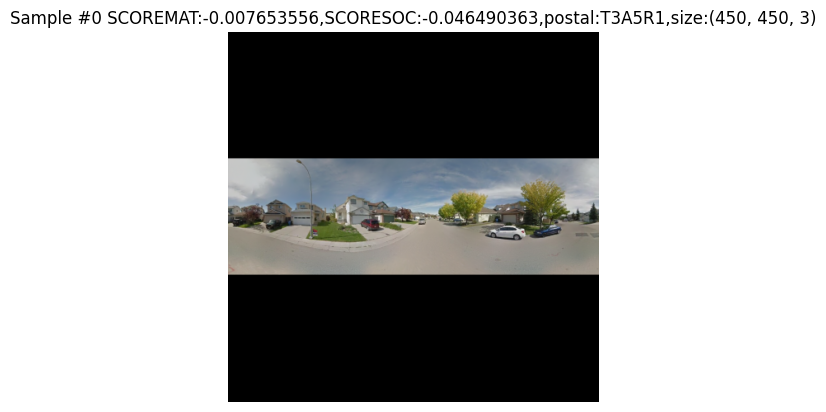

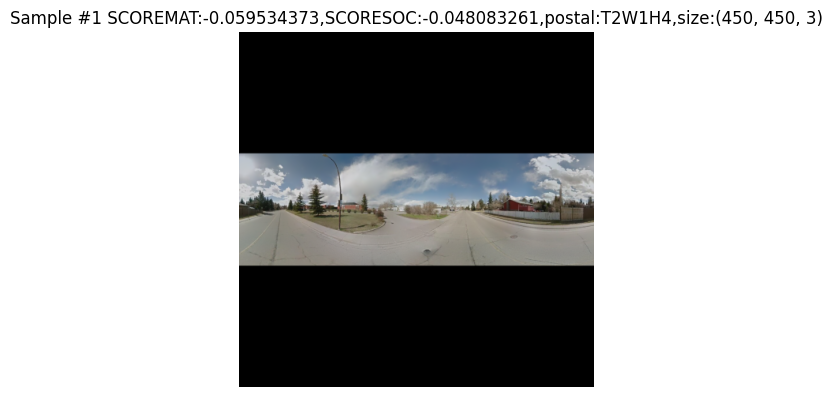

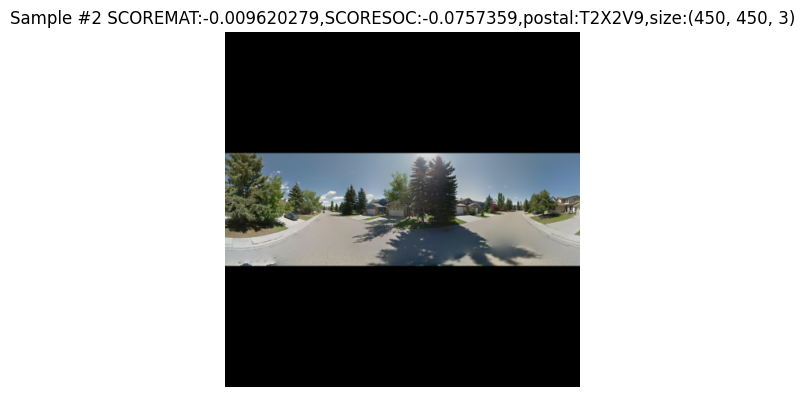

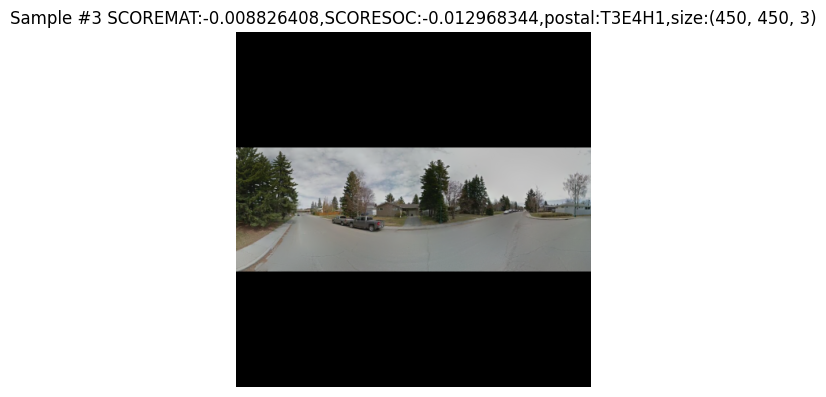

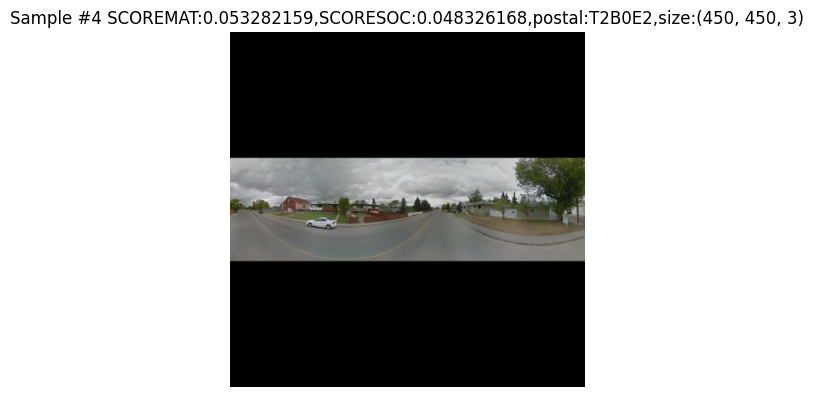

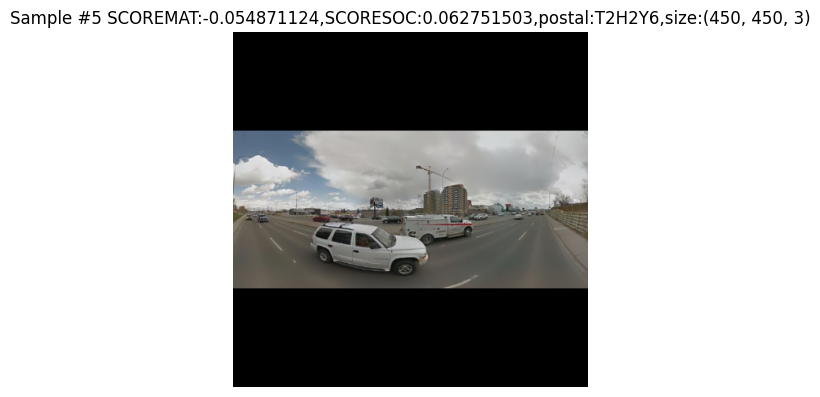

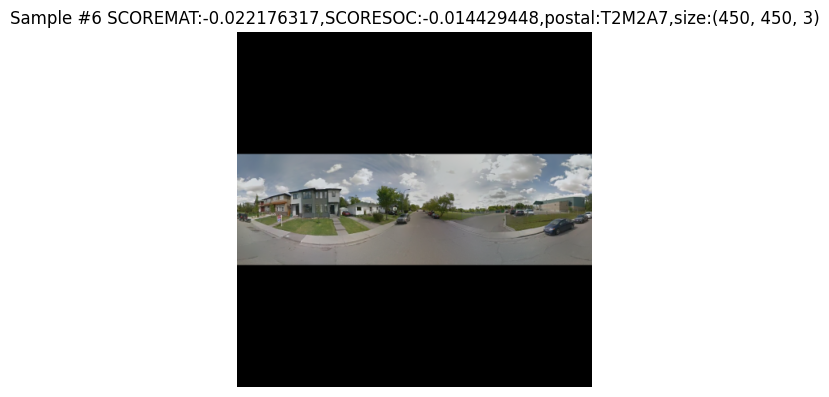

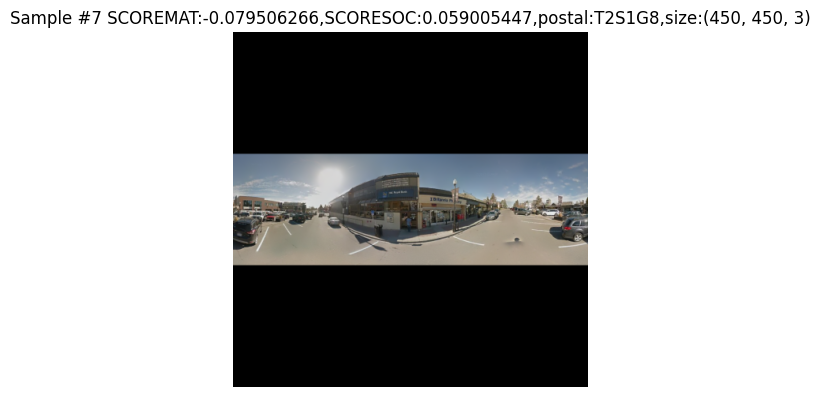

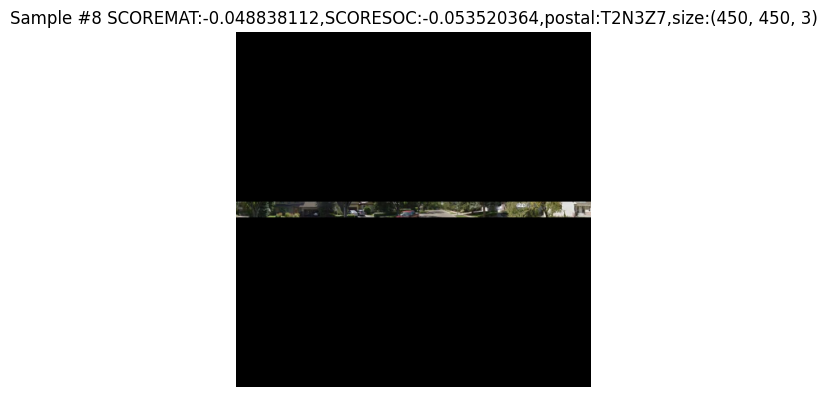

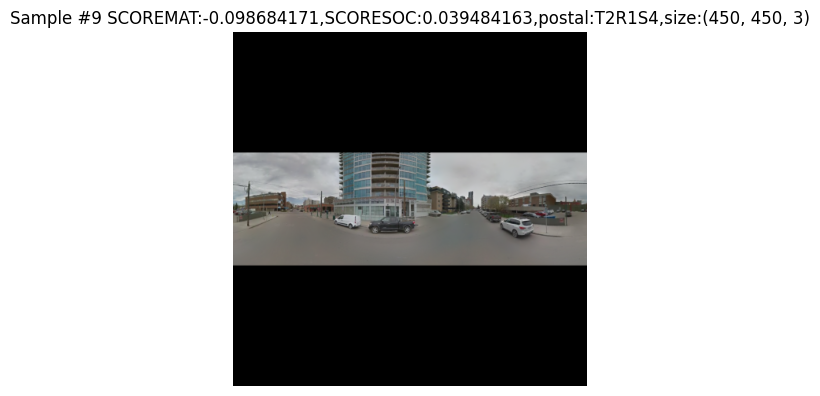

In [128]:
fig = plt.figure()

for i, sample in enumerate(depravation_dataset):
    if sample:
        plt.figure(figsize=[40, 40])
        ax = plt.subplot(1, 10, i + 1)
        plt.tight_layout()
        ax.set_title(f'Sample #{i} SCOREMAT:{sample["SCOREMAT"]},SCORESOC:{sample["SCORESOC"]},postal:{sample["POSTAL"]},size:{sample["image"].shape}')
        ax.axis('off')
        ax.imshow(sample['image'])

    if i == 9:
        plt.show()
        break

In [129]:
#split the dataset into  train and test set and generate train and validation loaders
train_set, val_set = torch.utils.data.random_split(
    depravation_dataset_transformed, [0.7, 0.3])
train_loader = DataLoader(train_set, batch_size=10,
                          shuffle=True, num_workers=0)
test_loader = DataLoader(val_set, batch_size=1,
                         shuffle=True, num_workers=0)

In [130]:
#Fine tune the model

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
for epoch in range(30):  # loop over the dataset multiple times
    model.train()
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        mat_score = data["SCOREMAT"].float()
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = model(data["image"].float())

        loss = criterion(outputs, mat_score)
        loss.backward()
        optimizer.step()
        # print statistics
        running_loss += loss.item()*data["SCOREMAT"].size(0)
    print(f'[epoch:{epoch + 1}] loss: {running_loss/len(train_loader):.3f}')
print('Finished Training')

[epoch:1] loss: 0.277
[epoch:2] loss: 0.065
[epoch:3] loss: 0.051
[epoch:4] loss: 0.043
[epoch:5] loss: 0.036


In [118]:
#Evaluate the model
predictions= []
scores = []
print("Evaluating The model")
model.eval()
for i, data in enumerate(test_loader, 0):
    score = data["SCORESOC"]
    prediction = model(data["image"].float())
    error = criterion(score, prediction)
    scores.append(score.item())
    predictions.append(prediction.item())

print(f'R-squared (R²) Score: {r2_score(scores, predictions)}')

Evaluating The model
R-squared (R²) Score: -0.3353335500674639


In [119]:
#Visualize the predictions and actual  scores
plot_data = pd.DataFrame({"predictions":predictions,"actual":scores})
fig = px.line(plot_data,y=[
               "predictions", "actual"])
fig.show()


## Classification

In [698]:
deprevation_cv = pd.read_csv(
    "../Data challenge dataset_complete_no_duplication.csv")

In [713]:
#Convert continous variable to  category 
label_encoder1 = LabelEncoder()
label_encoder2 = LabelEncoder()
deprevation_cv["SCOREMAT"] = label_encoder1.fit_transform(
    pd.cut(deprevation_cv["SCOREMAT"], 4, retbins=True, labels=["low","medium_low","medium_high","high"])[0])
deprevation_cv["SCORESOC"] = label_encoder2.fit_transform(
    pd.cut(deprevation_cv["SCORESOC"], 4, retbins=True, labels=["low","medium_low","medium_high","high"])[0])
deprevation_cv.to_csv(
    "../Data challenge dataset_complete_no_duplication_classification.csv")

In [55]:

# Use pretrained model
class_model = models.resnet101(weights=True)
for param in class_model.parameters():
    param.requires_grad = False
num_ftrs = class_model.fc.in_features

class_model.fc = nn.Sequential(nn.Linear(num_ftrs, 4))

/Users/yvesnsoganguimbous/miniconda3/envs/data622/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning:

Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.



In [58]:
depravation_dataset_class= zone_panorama_dataset(
    csv_file="../Data challenge dataset_complete_no_duplication_classification.csv", root_dir="../GSV_Images_AB", transform=transforms.Compose([Pad(),Augment(), Resize(),  ToTensor()]))

In [59]:
train_set_class, val_set_class = torch.utils.data.random_split(
    depravation_dataset_class, [0.7, 0.3])
train_loader_class = DataLoader(train_set_class, batch_size=10,
                          shuffle=True, num_workers=0)
test_loader_class = DataLoader(val_set_class, batch_size=1,
                         shuffle=True, num_workers=0)

In [60]:

criterion_2 = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(class_model.fc.parameters(
), lr=0.001, weight_decay=0.0, momentum=0.9)
loss_history = []
accuracy_history = []
for epoch in range(10):  # loop over the dataset multiple times
    class_model.train()
    running_loss = 0.0
    total = 0.0
    correct = 0.0
    for i, data in enumerate(train_loader_class, 0):
        # get the inputs; data is a list of [inputs, labels]
        mat_score = data["SCOREMAT"][:,0]
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = class_model(data["image"].float())

        loss = criterion_2(outputs, mat_score)
        loss.backward()
        optimizer.step()
        # print statistics
        _, predicted = torch.max(outputs, axis=1)

        running_loss += loss.item()
        total += mat_score.size(0)
        correct += (predicted == mat_score).sum().item()
        # Print statistics
        if i % 10 == 0 and i > 0:    # Print every 100 mini-batches
            print('[epoch: %d, batch: %5d] loss: %.3f' % (epoch + 1, i + 1 + i % 10, running_loss / 100))
            print('Accuracy of the model on the %d images: %.2f %%' % (total, 100 * correct / total))
            loss_history.append(running_loss / 100)
            accuracy_history.append(100 * correct / total)
            running_loss = 0.0
            total = 0.0
            correct = 0.0

[epoch: 1, batch:    11] loss: 0.105
Accuracy of the model on the 110 images: 49.09 %
[epoch: 1, batch:    21] loss: 0.091
Accuracy of the model on the 100 images: 56.00 %
[epoch: 1, batch:    31] loss: 0.086
Accuracy of the model on the 100 images: 48.00 %
[epoch: 1, batch:    41] loss: 0.095
Accuracy of the model on the 100 images: 55.00 %
[epoch: 1, batch:    51] loss: 0.102
Accuracy of the model on the 100 images: 50.00 %
[epoch: 1, batch:    61] loss: 0.101
Accuracy of the model on the 100 images: 47.00 %
[epoch: 2, batch:    11] loss: 0.093
Accuracy of the model on the 110 images: 54.55 %
[epoch: 2, batch:    21] loss: 0.082
Accuracy of the model on the 100 images: 61.00 %
[epoch: 2, batch:    31] loss: 0.088
Accuracy of the model on the 100 images: 54.00 %
[epoch: 2, batch:    41] loss: 0.088
Accuracy of the model on the 100 images: 49.00 %
[epoch: 2, batch:    51] loss: 0.086
Accuracy of the model on the 100 images: 51.00 %
[epoch: 2, batch:    61] loss: 0.092
Accuracy of the m

In [54]:
correct=0
for i, data in enumerate(test_loader_class, 0):
        # get the inputs; data is a list of [inputs, labels]
        mat_score = data["SCOREMAT"][:,0]
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = class_model(data["image"].float())

        loss = criterion_2(outputs, mat_score)
        # print statistics
        _, predicted = torch.max(outputs, axis=1)

        running_loss += loss.item()
        total += mat_score.size(0)
        correct += (predicted == mat_score).sum().item()
print('Accuracy of the model on the %d images: %.2f %%' % (total, 100 * correct / total))

Accuracy of the model on the 383 images: 39.95 %


In [ ]:
def predict(img: np.ndarray):
    """_summary_

    :param img: _description_
    :type img: np.ndarray
    """
    return class_model(data["image"].float())

In [ ]:
import shap
class_names= ["1","2","3","4"]
masker_blur = shap.maskers.Image("blur(128,128)", val_set[0].shape)
# create an explainer with model and image masker
explainer = shap.Explainer(predict, masker_blur, output_names=class_names)

# feed only one image
# here we explain two images using 100 evaluations of the underlying model to estimate the SHAP values
shap_values = explainer(
    Xtr[1:2],
    max_evals=n_evals,
    batch_size=batch_size,
    outputs=shap.Explanation.argsort.flip[:topk],
)

In [ ]:
import shap

[4]:
# python function to get model output; replace this function with your own model function.
def f(x):
    tmp = x.copy()

    return model(tmp)


# define a masker that is used to mask out partitions of the input image.
masker = shap.maskers.Image("inpaint_telea", X[0].shape)

# create an explainer with model and image masker
explainer = shap.Explainer(f, masker, output_names=class_names)

# here we explain two images using 500 evaluations of the underlying model to estimate the SHAP values
shap_values = explainer(X[1:3], max_evals=100, batch_size=50, outputs=shap.Explanation.argsort.flip[:4])